# Young Star Magnetic Models

Convergence of magnetic models is improved with a [new treatment of the peak magnetic field strength](http://nbviewer.ipython.org/github/gfeiden/Notebook/blob/master/Daily/20150728_peak_magnetic_field.ipynb) definition. Previously, it was defined as either $R_{\rm peak} = 0.5R_{\star}$ or $R_{\rm peak} = R_{\rm tach}$, where $R_{\rm tach}$ is the radial location of the interface region between the stellar radiation and convection zones (i.e., the tachocline). This caused problems for young star models as models start off fully convective but develop radiative cores as the central temperature increases throughout its gravitational contraction. Magnetic fields therefore jumped rapidly from a fully convective treatment to a partially convective treatment, leading to excessively large interior magnetic field strengths. To avoid this problem, the peak magnetic field strength is treated as either $R_{\rm peak} = 0.5R_{\star}$ or $R_{\rm peak} = R_{\rm tach}$, _whichever is larger_, in all cases.

Two small grids of magnetic models are computed with GS98 and GAS07 solar abundances. These may be incorporated into the Young Star manuscript, where we present models of young stars that have now been used in several publications (e.g., [Malo et al. 2014](http://adsabs.harvard.edu/abs/2014arXiv1406.6750M); [Herczeg & Hillenbrand 2015](http://adsabs.harvard.edu/abs/2015arXiv150506518H)). However, these models are computed, specifically, at the request of I. Song, who wishes to incorporate magnetic models into an analysis. The tracks themselves will not be incorporated into the GitHub repo, as publishing the full grid would require too much disk space, but they are available [upon request by creating an "issue"](https://github.com/gfeiden/Notebook/issues). 

__Update__: raw magnetic mass tracks are contained in a tarball in the [`files/` directory](https://github.com/gfeiden/Notebook/tree/master/Daily/files) with the extension `_mtrks.tgz`.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Magnetic Mass Tracks

We'll start with loading mass tracks from the GAS07 solar abundance subset. These adopt surface boundary conditions from the MARCS model atmosphere structures. While we typically recommend surface boundary conditions be attached at an optical depth where $\tau_{\rm ross} \ge 50$, the magnetic models are computed by fitting surface boundary conditions where $\tau_{\rm ross} \ge 10$. Magnetic fields largely affect the super-adiabiatic layers near the stellar surface, with deeper field strenghts playing a less critical role ([Feiden & Chaboyer 2013](http://adsabs.harvard.edu/abs/2013ApJ...779..183F), [2014](http://adsabs.harvard.edu/abs/2014A%26A...571A..70F)). However, the motivation for attaching the boundary conditions at larger optical depths is to provide a better treatment of super-adiabatic layers where radiation and convection are both significnat contributors to the total energy flux ([Chabrier & Baraffe 1997](http://adsabs.harvard.edu/abs/1997A%26A...327.1039C)), which is in opposition to our efforts of including the effects of magnetic fields. 

We provide a compromise by fixing the surface boundary conditions at higher layer in the star. This provides a sufficiently large super-adiabatic layer to give the magnetic field a reasonable influence, while still providing a reliable estimate of the surface conditions that help set the overall thermal structure of the star.

In [2]:
masses = np.arange(0.1, 0.96, 0.05)  # list of masses

## Magnetic Isochrones

Process the magnetic mass tracks into isochrones. Since mass tracks are computed with a relatively course mass resolution ($0.05 M_{\odot}$), spline interpolation is used to smooth the resulting isochrones with a finer mass resolution. 

Below, a grid of isochrones is computed from 5 to 30 Myr in steps of 1 Myr.

In [3]:
from scipy.interpolate import interp1d

ages = np.arange(5.0e6, 3.1e7, 1.0e6)  # ages requested

### Dartmouth & MARCS; Solar abundance: Grevesse, Asplund, & Sauval 2007

In [4]:
# open output file objects 
output_files = [open('files/dmestar_{:07.1f}myr_gas07_z+0.00_a+0.00_mag25kG.iso'.format(age/1.0e6), 'w') 
                for age in ages]

trk_directory = '../../evolve/dmestar/trk/gas07/p000/a0/amlt2040/mag25kG'
for mass in masses:
    trk_filename = 'm{:04.0f}_GAS07_p000_p0_y26_mlt2.040_mag25kG.trk'.format(mass*1000.)
    try:
        gas07_trk = np.genfromtxt('{0}/{1}'.format(trk_directory, trk_filename), usecols=(0, 1, 2, 3, 4, 8))
    except IOError:
        continue
    
    # extract only relevant age chunk for easier interpolation
    gas07_trk = np.array([time_step for time_step in gas07_trk if 1.0e6 <= time_step[0] <= 5.0e7])
    
    # generate linear interpolation curve as a function of age
    try:
        icurve = interp1d(gas07_trk[:, 0], gas07_trk[:, 1:], kind='linear', axis=0)
    except IndexError:
        continue
    
    # extract properties at the requested age
    trk_props = icurve(ages)
    
    i = 0
    for props in trk_props:
        s = '{:6.3f}'.format(mass)
        for prop in props:
            if np.isnan(prop) or prop < -12.0:
                prop = -12.0
            s += '{:14.6f}'.format(prop)
        s += '\n'
        output_files[i].write(s)
        i += 1
    #print "{:4.2f} Mo Track Processed.".format(mass)
    
# close output files
for f in output_files:
    f.close()

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/interpolate/interpolate.py:466: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Interpolate isochrones onto a finer mass grid.

In [5]:
fine_mass_grid = np.arange(0.1, 0.95, 0.02)
for age in ages:
    iso_filename = 'files/dmestar_{:07.1f}myr_gas07_z+0.00_a+0.00_mag25kG.iso'.format(age/1.0e6)
    isochrone = np.genfromtxt(iso_filename)
    
    # generate interpolation curve
    icurve = interp1d(isochrone[:,0], isochrone[:,1:], axis=0, kind='slinear')
    
    # interpolate onto a finer mass grid
    fine_isochrone = icurve(fine_mass_grid)
    fine_isochrone = np.column_stack((fine_mass_grid, fine_isochrone))
    
    # write header
    header  = 'Dartmouth Stellar Evolution Model: Quick Isochrone \n\n'
    header += 'Age = {:7.1f} Myr   [Fe/H] = {:+5.2f}   [a/Fe] = {:+5.2f} \n\n'.format(age/1.e6, 0.0, 0.0)
    header += '{:^14} {:^14} {:^14} {:^14} {:^14} {:^14}'.format('Mass', 'log(Teff)', 'log(g)', 'log(L/Lo)', 
                                                                 'log(R/Ro)', 'A(Li)')
    
    # overwrite original file
    np.savetxt(iso_filename, fine_isochrone, fmt='%14.6f', header=header)

Magnetic isochrones are stored in the directory [`files/`](https://github.com/gfeiden/Notebook/tree/master/Daily/files/) and follow the format outline in the two code snippets above. We can take a quick look at some of the proeprties of these isochrones and how they compare to standard stellar evolution isochrones (i.e., without a magnetic perturbation).

A tarball with all of the above computed isochrones can be found in [`files/dmestar_gas07_z+0.00_a+0.00_mag25kG.tgz`](https://github.com/gfeiden/Notebook/tree/master/Daily/files/dmestar_gas07_z+0.00_a+0.00_mag25kG.tgz).

### Dartmouth & PHOENIX; Solar abundance: Grevesse & Sauval 1998

In [6]:
masses = np.arange(0.10, 0.86, 0.05)  # higher masses did not converge (investigating)

In [7]:
# open output file objects 
output_files = [open('files/dmestar_{:07.1f}myr_gs98_z+0.00_a+0.00_mag25kG.iso'.format(age/1.0e6), 'w') 
                for age in ages]

trk_directory = '../../evolve/dmestar/trk/gs98/p000/a0/amlt1884/mag25kG'
for mass in masses:
    trk_filename = 'm{:04.0f}_GS98_p000_p0_y28_mlt1.884_mag25kG.trk'.format(mass*1000.)
    try:
        gs98_trk = np.genfromtxt('{0}/{1}'.format(trk_directory, trk_filename), usecols=(0, 1, 2, 3, 4, 8))
    except IOError:
        continue
    
    # extract only relevant age chunk for easier interpolation
    gs98_trk = np.array([time_step for time_step in gs98_trk if 1.0e6 <= time_step[0] <= 5.0e7])
    
    # generate linear interpolation curve as a function of age
    try:
        icurve = interp1d(gs98_trk[:, 0], gs98_trk[:, 1:], kind='linear', axis=0)
    except IndexError:
        continue
    
    # extract properties at the requested age
    trk_props = icurve(ages)
    
    i = 0
    for props in trk_props:
        s = '{:6.3f}'.format(mass)
        for prop in props:
            if np.isnan(prop) or prop < -12.0:
                prop = -12.0
            s += '{:14.6f}'.format(prop)
        s += '\n'
        output_files[i].write(s)
        i += 1
    #print "{:4.2f} Mo Track Processed.".format(mass)
    
# close output files
for f in output_files:
    f.close()

Interpolate onto a finer mass grid,

In [8]:
fine_mass_grid = np.arange(0.1, 0.85, 0.02)
for age in ages:
    iso_filename = 'files/dmestar_{:07.1f}myr_gs98_z+0.00_a+0.00_mag25kG.iso'.format(age/1.0e6)
    isochrone = np.genfromtxt(iso_filename)
    
    # generate interpolation curves
    icurve = interp1d(isochrone[:,0], isochrone[:,1:], axis=0, kind='slinear')
    
    # interpolate onto a finer mass grid
    fine_isochrone = icurve(fine_mass_grid)
    fine_isochrone = np.column_stack((fine_mass_grid, fine_isochrone))
    
    # write header
    header  = 'Dartmouth Stellar Evolution Model: Quick Isochrone \n\n'
    header += 'Age = {:7.1f} Myr   [Fe/H] = {:+5.2f}   [a/Fe] = {:+5.2f} \n\n'.format(age/1.e6, 0.0, 0.0)
    header += '{:^14} {:^14} {:^14} {:^14} {:^14} {:^14}'.format('Mass', 'log(Teff)', 'log(g)', 'log(L/Lo)', 
                                                                 'log(R/Ro)', 'A(Li)')
    
    # overwrite original file
    np.savetxt(iso_filename, fine_isochrone, fmt='%14.6f', header=header)

Magnetic isochrones are stored in the directory [`files/`](https://github.com/gfeiden/Notebook/tree/master/Daily/files/) and follow the format outline in the two code snippets above. We can take a quick look at some of the proeprties of these isochrones and how they compare to standard stellar evolution isochrones (i.e., without a magnetic perturbation).

A tarball with all of the above computed isochrones can be found in [`files/dmestar_gs98_z+0.00_a+0.00_mag25kG.tgz`](https://github.com/gfeiden/Notebook/tree/master/Daily/files/dmestar_gs98_z+0.00_a+0.00_mag25kG.tgz).

### Simple Diagnostic Plots

Here are some simple diagnostic figures to assess that isochrones look smooth and do not deviate too significantly from expectation (i.e., they're smooth and properties change monotonically). Plot a few isochrones: 5 Myr, 12 Myr, and 30 Myr.

In [9]:
# GS98 isochrones
gs98_05 = np.genfromtxt('files/dmestar_00005.0myr_gs98_z+0.00_a+0.00_mag25kG.iso')
gs98_12 = np.genfromtxt('files/dmestar_00012.0myr_gs98_z+0.00_a+0.00_mag25kG.iso')
gs98_30 = np.genfromtxt('files/dmestar_00030.0myr_gs98_z+0.00_a+0.00_mag25kG.iso')

# GAS07 isochrones
gas07_05 = np.genfromtxt('files/dmestar_00005.0myr_gas07_z+0.00_a+0.00_mag25kG.iso')
gas07_12 = np.genfromtxt('files/dmestar_00012.0myr_gas07_z+0.00_a+0.00_mag25kG.iso')
gas07_30 = np.genfromtxt('files/dmestar_00030.0myr_gas07_z+0.00_a+0.00_mag25kG.iso')

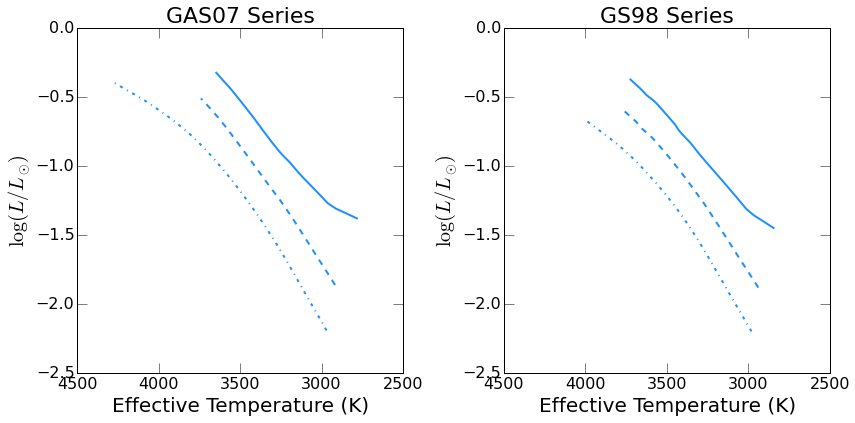

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].set_title('GAS07 Series', fontsize=22.)
ax[1].set_title('GS98 Series', fontsize=22.)
for axis in ax:
    axis.set_xlabel('Effective Temperature (K)', fontsize=20.)
    axis.set_ylabel('$\\log (L / L_{\\odot})$', fontsize=20.)
    axis.set_xlim(4500., 2500.)
    axis.set_ylim(-2.5, 0.0)
    axis.tick_params(which='major', axis='both', length=10., labelsize=16.)

# GAS07 series
ax[0].plot(10.0**gas07_05[:, 1], gas07_05[:, 3], '-',  lw=2, color='#1e90ff')
ax[0].plot(10.0**gas07_12[:, 1], gas07_12[:, 3], '--', lw=2, color='#1e90ff')
ax[0].plot(10.0**gas07_30[:, 1], gas07_30[:, 3], '-.', lw=2, color='#1e90ff')

# GS98 series
ax[1].plot(10.0**gs98_05[:, 1], gs98_05[:, 3], '-',  lw=2, color='#1e90ff')
ax[1].plot(10.0**gs98_12[:, 1], gs98_12[:, 3], '--', lw=2, color='#1e90ff')
ax[1].plot(10.0**gs98_30[:, 1], gs98_30[:, 3], '-.', lw=2, color='#1e90ff')

fig.tight_layout()

There looks to be some noise in the GS98 isochrones at the highest temperatures, which is likely related to the convergence issues with those above $0.90 M_{\odot}$. Nevertheless, the isochrones appear quite smooth.

Quick look at Li depletion curves. ~~(note: due to issues with NaNs in the 28+ Myr isochrones, switching from 30 Myr to 27 Myr.)~~

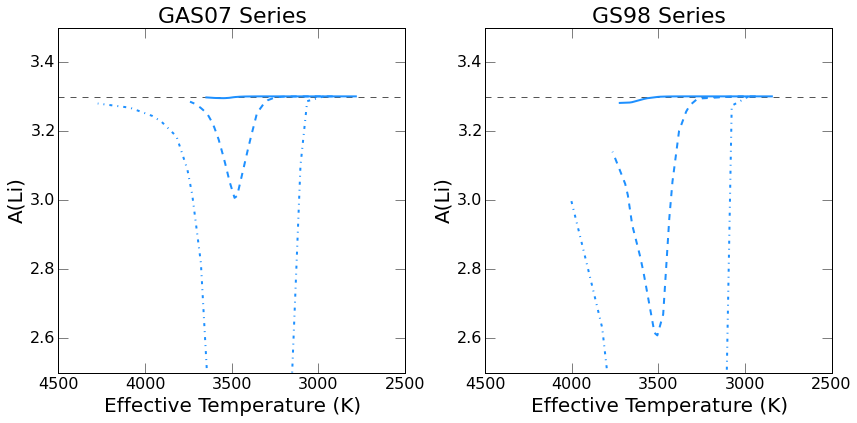

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].set_title('GAS07 Series', fontsize=22.)
ax[1].set_title('GS98 Series', fontsize=22.)
for axis in ax:
    axis.set_xlabel('Effective Temperature (K)', fontsize=20.)
    axis.set_ylabel('A(Li)', fontsize=20.)
    axis.set_xlim(4500., 2500.)
    axis.set_ylim(2.5, 3.5)
    axis.tick_params(which='major', axis='both', length=10., labelsize=16.)
    axis.plot([4500., 2500.], [3.30, 3.30], '--', lw=1, color="#555555")

# GAS07 series
ax[0].plot(10.0**gas07_05[:, 1], gas07_05[:, 5], '-',  lw=2, color='#1e90ff')
ax[0].plot(10.0**gas07_12[:, 1], gas07_12[:, 5], '--', lw=2, color='#1e90ff')
ax[0].plot(10.0**gas07_30[:, 1], gas07_30[:, 5], '-.', lw=2, color='#1e90ff')

# GS98 series
ax[1].plot(10.0**gs98_05[:, 1], gs98_05[:, 5], '-',  lw=2, color='#1e90ff')
ax[1].plot(10.0**gs98_12[:, 1], gs98_12[:, 5], '--', lw=2, color='#1e90ff')
ax[1].plot(10.0**gs98_30[:, 1], gs98_30[:, 5], '-.', lw=2, color='#1e90ff')

fig.tight_layout()

There are interpolation issues for ages greater than 28 Myr, as at least one of the models in the course grid had A(Li) = NaN. This leads to all interpolate values coming back as NaNs. And A(Li) does not appear to be so smooth, with a random bump at low temperatures that is clearly indicative of an artifact of the spline interpolation.

__Update 01__: NaNs have now been removed. The gap in the GS98 A(Li) figure at 30 Myr is due to values listed as `-inf`.

__Update 02__: `-inf` values have now been replaced by actual values.

## References

If you use these models, please consider citing the following papers depending on the context of your work. Each potential reference is preceeded by a brief description of the paper.

Original inspiration and basis for the magnetic Dartmouth stellar evolution models:

> Lydon & Sofia (1995), ApJS, 101, 357 ([ADS](http://adsabs.harvard.edu/abs/1995ApJS..101..357L)).

Framework for the magnetic models is the Dartmouth stellar evolution program (DSEP):

> Dotter, Chaboyer, Jevremovic, _et al._ (2008), ApJS, 178, 89 ([ADS](http://adsabs.harvard.edu/abs/2008ApJS..178...89D)).

Description and first demonstration of the magnetic Dartmouth stellar evolution code:

> Feiden & Chaboyer (2012), ApJ, 761, 30 ([ADS](http://adsabs.harvard.edu/abs/2012ApJ...761...30F)).

Demonstration of the magnetic code on three main sequence eclipsing binary systems whose stars are believed to possess a radiative core. Showed that magnetic field perturbation in the super-adiabatic region governs how the model is affected by the presence of global magnetic perturbation:

> Feiden & Chaboyer (2013), ApJ, 779, 183 ([ADS](http://adsabs.harvard.edu/abs/2013ApJ...779..183F)).

Demonstration of the magnetic code on two main sequence eclipsing binary systems whose stars are believed to be fully convective. Instituted the fixed peak magnetic field strength at $0.15 R_{\odot}$ for fully convective stars:

> Feiden & Chaboyer (2014), ApJ, 786, 53 ([ADS](http://adsabs.harvard.edu/abs/2014ApJ...786...53F)).

First application of magnetic Dartmouth stellar evolution models to young stars. Implemented the condition that the peak magnetic field strength occurs at $0.50 R_{\odot}$ for fully convective stars:

> Malo, Doyon, Feiden, _et al._ (2014), ApJ, 792, 37 ([ADS](http://adsabs.harvard.edu/abs/2014ApJ...792...37M))